In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate
import seaborn as sns
import sys
from xgboost import XGBClassifier
import statistics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Defining train_model function

In [2]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='merror', gpu_id=0)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
        }
    param_grid = {
        'n_estimators': [100, 1000, 2000],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7],
        'min_child_weight': [1, 2, 3, 4],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'colsample_bylevel': [0.5, 1.0],
        'colsample_bynode': [0.5, 1.0],
    } 
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=5)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(estimator=best_model, X=X, y=y, cv=kfold, scoring = scoring, n_jobs=5)
    predictions = best_model.predict(X_test)
    return results, best_model, predictions, y_test

# Main code

In [3]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

c:\Users\Masloriy\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:01:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\Masloriy\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warn

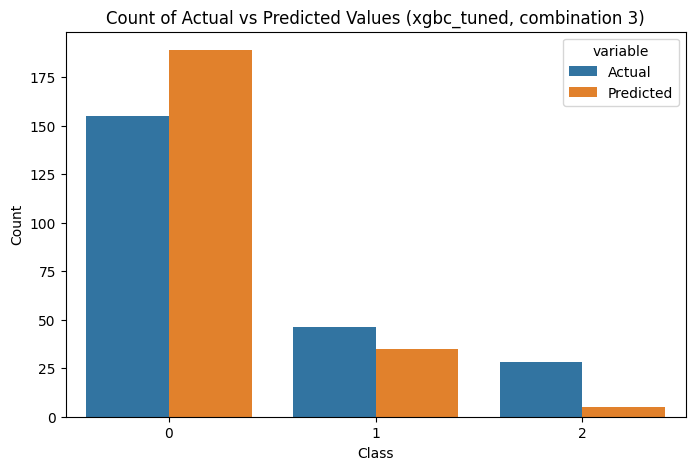

In [4]:
# Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns=["day.type"])
y = df["day.type"] 
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('xgbc_tuned_combination_3.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (xgbc_tuned, combination 3)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('xgbc_tuned_combination_3.png', dpi=300)

# Iteration 2

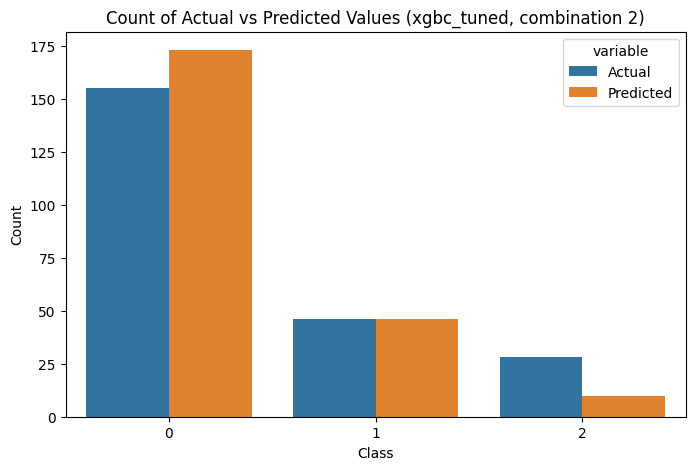

In [5]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('xgbc_tuned_combination_2.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (xgbc_tuned, combination 2)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('xgbc_tuned_combination_2.png', dpi=300)

# Iteration 3

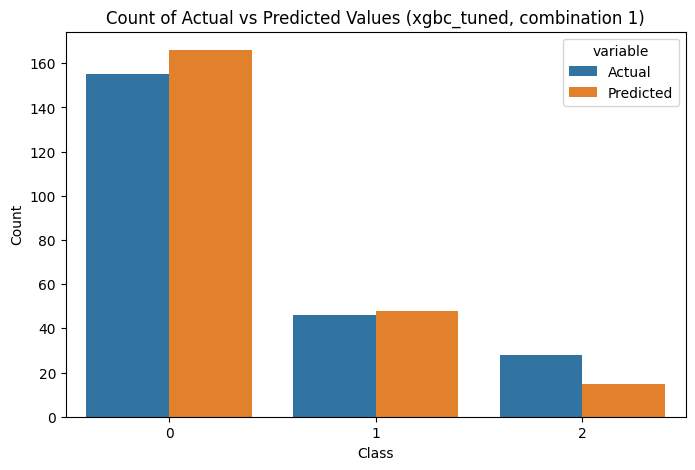

In [6]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('xgbc_tuned_combination_1.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (xgbc_tuned, combination 1)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('xgbc_tuned_combination_1.png', dpi=300)